<a href="https://colab.research.google.com/github/201ssc/python_test1/blob/main/6_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98_%EC%B2%B4%EC%9D%B8%EA%B3%BC_%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import QuantileTransformer, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=3)
sns.set(rc = {'figure.figsize':(10,6)})

from pandas.core.common import random_state

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import os
import sys
if 'google.colab' in sys.modules and not os.path.isdir('mglearn'):
    # 사이킷런 최신 버전을 설치합니다.
    !pip install -q --upgrade scikit-learn
    # mglearn을 다운받고 압축을 풉니다.
    !wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
    !tar -xzf mglearn.tar.gz
    !wget -q -O data.tar.gz https://bit.ly/data-tar-gz
    !tar -xzf data.tar.gz
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    fm._rebuild()

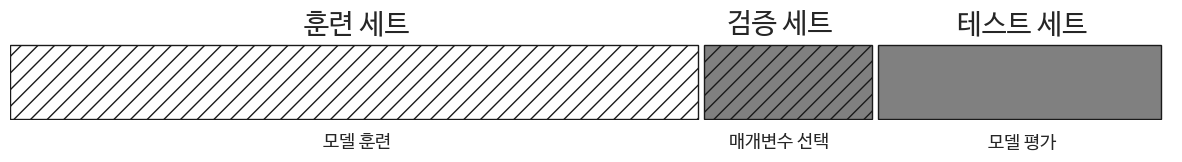

In [ ]:
import sklearn
from preamble import *
import matplotlib

# 나눔 폰트를 사용합니다.
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
mglearn.plots.plot_threefold_split()

# 6 알고리즘 체인과 파이프 라인

입력 데이터의 표현 형태에 매우 민감한 머신러닝 알고리즘이 많다.
데이터의 스케일을 조정하고 특성을 연결하는 것 부터 비지도 학습으로 직접 특성을 만드는 것까지 한다. 따라서 대부분 머신러닝 앱은 하나의 알고리즘으로 이워져 있지 않고 여러 단계의 처리과정과 머신러닝 모델이 연결되어있다.
이번 장에선 데이터의 변환 과정과 머신러닝 모델을 쉽게 연결해주는  Pipeline 파이썬 클래스를 다루어 보겠다. 특히 Pipeline 과 GridSearchCV 를 함께 사용하여 각 처리 단계에서 필요한 매개 변수 탐색을 동시에 수행할 것이다.
\
모델 체인의 좋은 예로, cancer 데이터셋을 MinMaxScaler로 전처리를 해서 커널 SVM의 성능을 크게 향상시킨 것을 들 수 있다. 다음은 데이터를 분할 하고 최솟값, 최댓값을 찾아 데이터의 스케일으 바꾸고 SVM을 훈련시키는 코드이다.

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산한다.
scaler = MinMaxScaler().fit(X_train)

# 훈련 데이터의 스케일을 조정한다. (0~1 사이값으로 변경)
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킨다.
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산한다.
X_test_scaled = scaler.transform(X_test)
print('테스트 점수: {:.2f}'.format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


## 6.1 데이터 전처리와 매개변수 선택
5장에서 처럼 GridSearchCV 를 사용해 더 좋은 SVC 매개 변수를 찾으려한다. 어떻게 해야할까.

In [ ]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것이다. 실제론 이렇게 사용하면 안된다.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid, cv=5)            
grid.fit(X_train_scaled, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 점수: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('최적의 매개변수: ', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


스케일을 조정한 데이터를 사용해서 SVC의 매개변수에 대해 그리드서치를 수행했다. 그러나 이 코드에는 교모한 함정이 있다. 데이터의 최솟값과 그 최댓값을 계산할 때 학습을 위해 훈련 세트에 있는 모든 데이터를 사용했다. 그런 다음 스케일이 조정된 훈련 데이터에서 교차 검증을 사용해 그리드 서치를 수행했다. 교차 검증의 각 분할에서 원본 훈련 세트 데이터의 어떤 부분은 훈련 폴드가 되고 어떤 부분은 검증 폴드가 된다. 검증 폴드는 훈련 폴드로 학습된 모델이 새로운 데이터에 적용할 때의 성능을 측정하는 데에 사용한다. 그러나 데이터 스케일을 조정할때 검증 폴드에 들어있는 정보까지 이미 사용한다. 즉 데이터의 스케일을 조정하기 위해 검증폴더의 데이터 까지 이용했고 이는 새로운 데이터가 모델에 나타날때와는 완전히 다르다. 새로운 데이터가 관측되면, 이 데이터는 훈련 데이터의 스케일을 조정에 사용되지 않는 것이라, 최댓 최솟 훈련 데이터와 다를 수 있다.

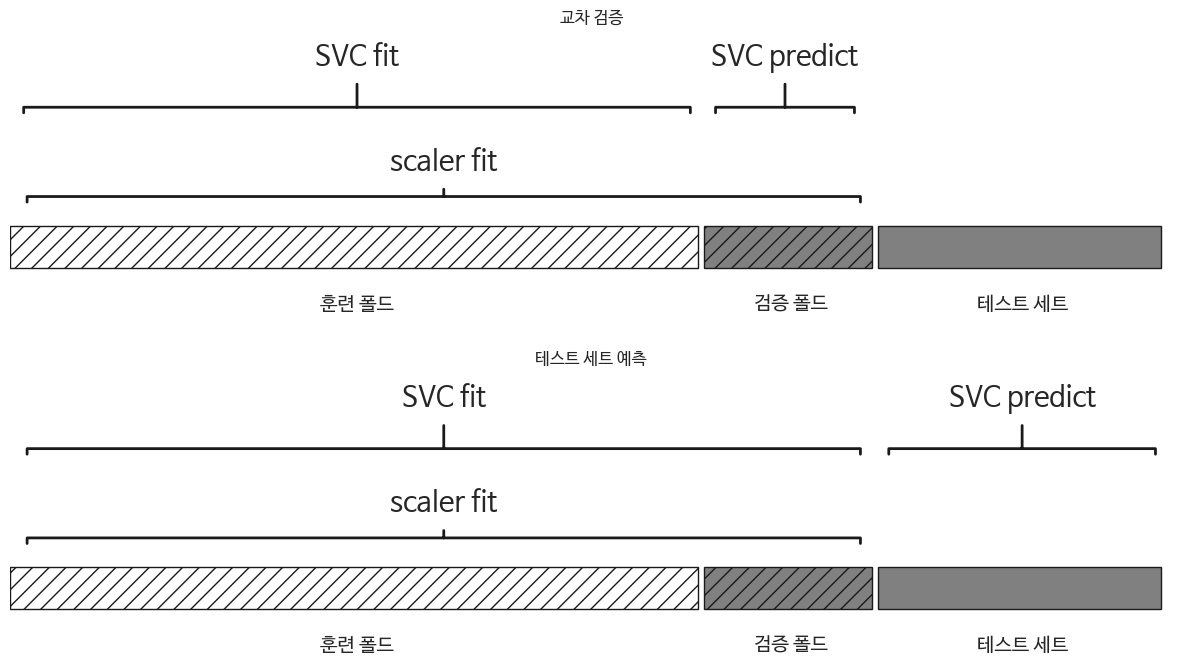

In [ ]:
# 6.1 교차검증 동안 데이터 처리와 최종 평가가 어떻게 다른지 시각화
mglearn.plots.plot_improper_processing()
# 교차 검증 반복 밖에서 전처리가 될 때 데이터 사용 형태

이 문제를 해결하기 위해서 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄져야 한다. sklearn 에서 cross_val_socre 함수와 GridSearchCV 로 이런 방식을 구현하려면 Pipeline을 사용한다. Pipeline 은 fit, predict, score 메서드를 제고하고 scikit-learn 의 다른 모델들과 유사하게 작동한다.

## 6.2 파이프라인 구축하기
SVM을 훈련시키는 워크플로를 pipeline을 사용해서 어떻게 표현하는 지 알아보자

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [ ]:
print('테스트 점수: {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수: 0.97
